# Linelist - Diagnosis
### Predicting the outcome


This is the continuation of the line list notebook of the same study

The pre-processing steps are the same as in the Line list notebook.
What changes is that we only keep the ebola positive patients

In [100]:
# Tool to calculate carbon footprint
from cumulator import base

cumulator = base.Cumulator()
cumulator.on()

In [101]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sys
import eli5
sys.path.append('STUDIES')
from proj2_HELPERS_ import *
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from yellowbrick.features import Manifold
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import FeatureImportances

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
# Path to dataset (change)

df_linelist = pd.read_csv('../../Original dataset/EGOYQN_Gueckedou_linelist_cleaned_pos_and_neg_2019_November_ANSI.csv', encoding = 'ISO-8859-1')
df_linelist.head()

,msfid,mcid,datmac,transit,admis,gkdid,datgck,age,sex,respref,...,pcr2ct,epistat,commun,currstat,exdat,outold,outcome,locdec,condat,source
0,G1,Absent,01/01/1900,Non,Non,Absent,01/01/1900,60.0,2,14,...,.,2,1,1,2/22/2014,3,2,GUECKEDOU,02/02/2014,.
1,G10,Absent,01/01/1900,Non,Non,Absent,01/01/1900,35.0,2,14,...,.,1,0,1,3/17/2014,1,2,Hosto GKD,2/25/2014,.
2,G100,Absent,01/01/1900,Non,Oui,GKD25,04/11/2014,40.0,1,14,...,.,1,0,2,4/20/2014,8,1,na,01/01/1900,.
3,G1000,MC260,9/17/2014,Non,Oui,GKD775,01/01/1900,40.0,1,25,...,.,1,0,1,9/19/2014,3,2,Non rempli,01/01/1900,.
4,G1001,Absent,9/17/2014,Non,Oui,GKD776,9/19/2014,8.0,2,25,...,.,1,0,1,9/21/2014,3,2,Non rempli,01/01/1900,.


### Outcome 

In [103]:
# apply dictionnary to get -1, 0, 1 for df_outcome  --> 0: recovery, 1: death, -1: unknown
df_outcome  = df_linelist['outcome']
dict_outcome_answer = {'1':'0', '2':'1', '3':'-1', '4':'-1', '9':'-1', '.':'-1'}
df_outcome = df_outcome.astype('str')
df_outcome = df_outcome.apply(lambda x : dict_outcome_answer[x])

In [104]:
# Taken from Line list for shorter Notebooks
df_out = pd.read_csv('linelist_out.csv')

# For the third dataframe
df_ml = pd.read_csv("Help_frame.csv")

## First proposition of data frame

In [105]:
df_out_simple = delete_minus1(df_out)
df_out_simple.head()

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,outcome
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0


In [106]:
remaining_symptoms = ['symfev', 'symvom', 'symdiar', 'symanor', 'symdouab', 'symdouar', 
                      'symceph', 'symhoq', 'symasth', 'symhemor']

# then do the same with zeros
df_out_simple.replace(0, np.nan, inplace=True)
df_out_simple.dropna(axis=0, how='all', subset=remaining_symptoms, inplace=True)
df_out_simple.replace(np.nan, 0, inplace=True)
df_out_simple.head()

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,outcome
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0


In [107]:
y_out_simple = df_out_simple['outcome'].astype(float)
X_out_simple = df_out_simple.drop(['outcome'], axis = 1).astype(float)

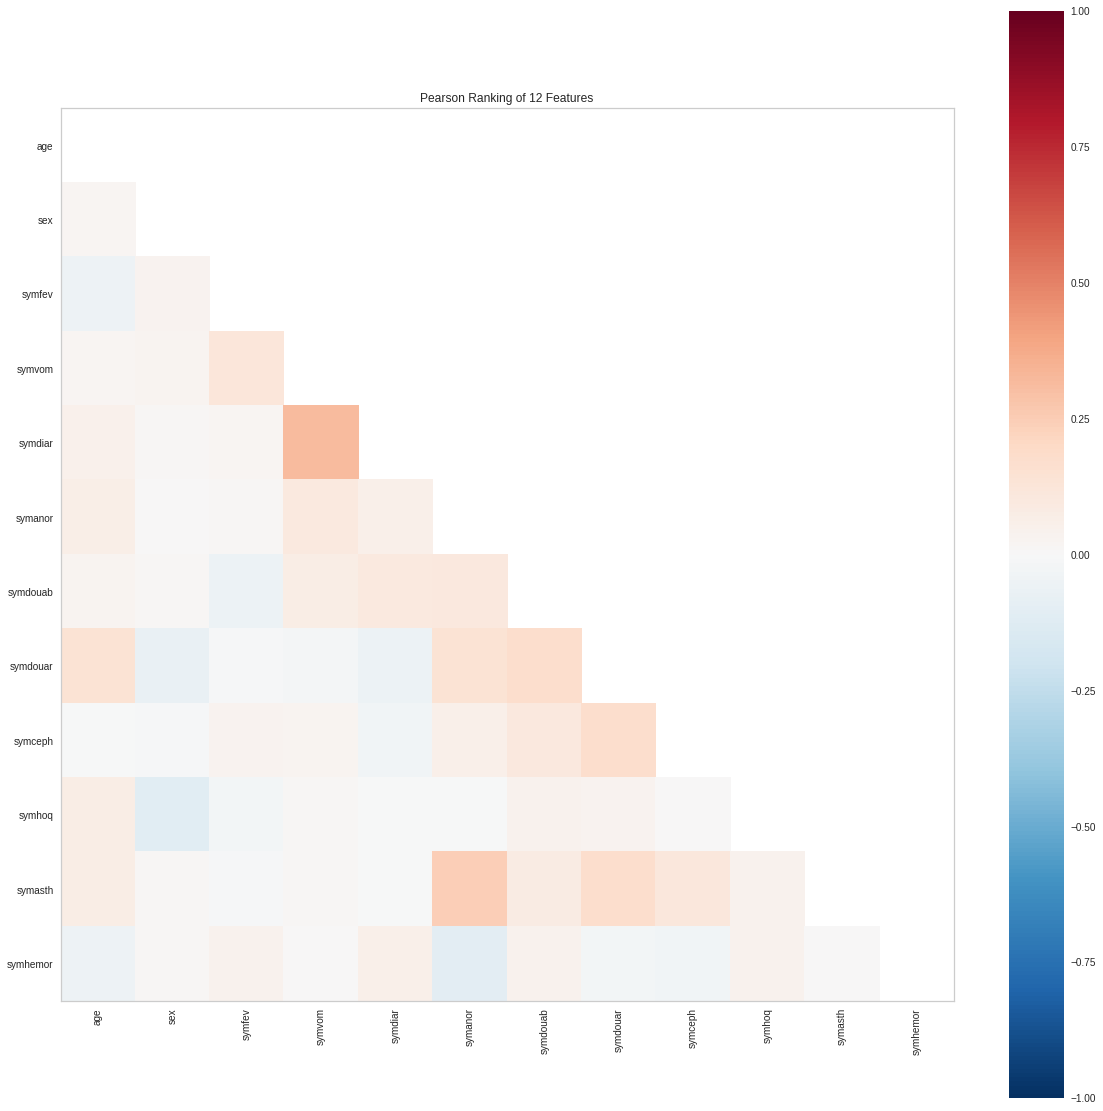

In [108]:
Corr_vision(X_out_simple)

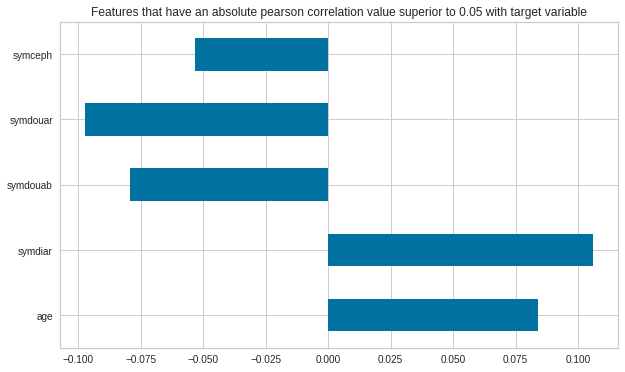

In [109]:
X_y = X_out_simple.join(y_out_simple)
corr_matrix = X_y.corr()

corr_y = corr_matrix['outcome']
threshold = 0.05
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

In [110]:
y_out_simple.value_counts()

1.0    760
0.0    433
Name: outcome, dtype: int64

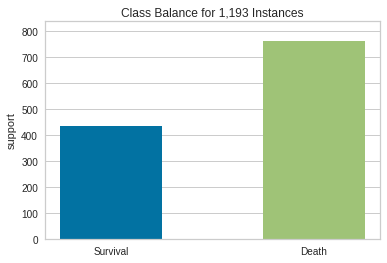

In [111]:
Imbalance_out(y_out_simple)

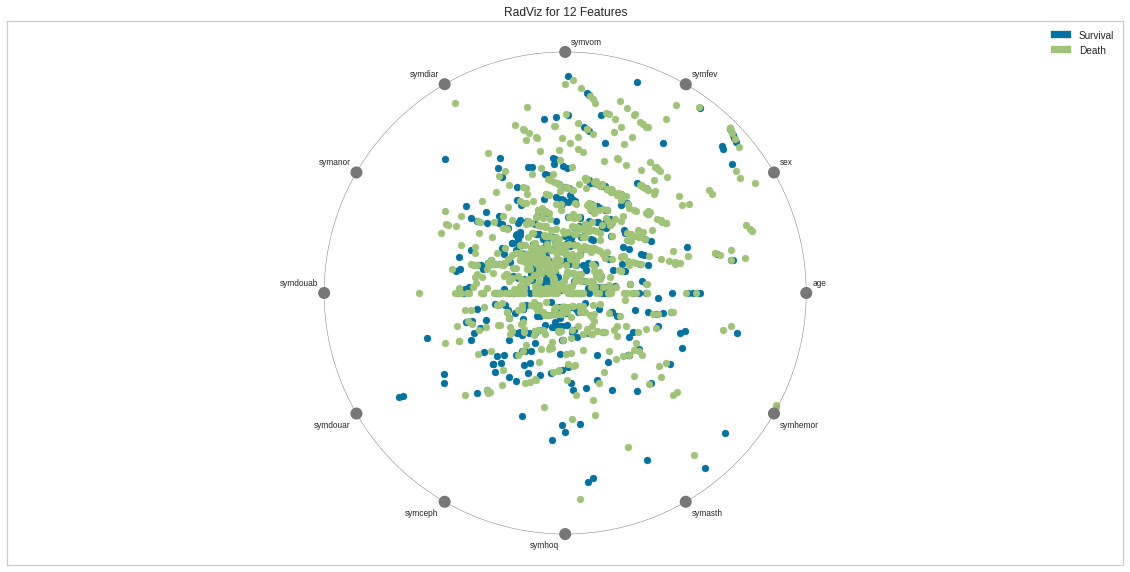

In [112]:
Rad_vision_out(X_out_simple, y_out_simple)

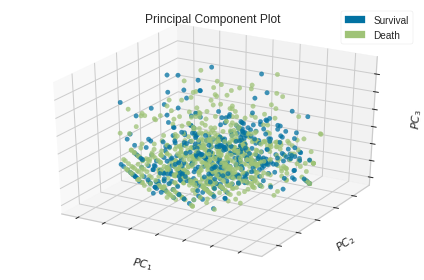

In [113]:
PCA_vision_3D_out(X_out_simple, y_out_simple.astype('int'))

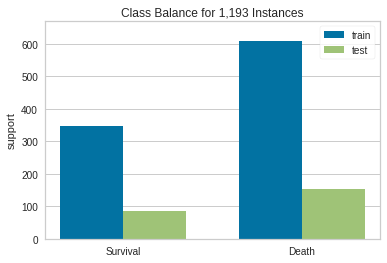

In [114]:
X_out_simple_train, X_out_simple_test, y_out_simple_train, y_out_simple_test = train_test_split(X_out_simple, y_out_simple, test_size=0.2, random_state=123, stratify=y_out_simple)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Survival', 'Death'])

visualizer.fit(y_out_simple_train, y_out_simple_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [115]:
# standardize age for df_out_simple

scaler1 = StandardScaler()
X_out_simple_train['age'] = scaler1.fit_transform(X_out_simple_train['age'].to_numpy().reshape(-1, 1))  
X_out_simple_test['age'] = scaler1.transform(X_out_simple_test['age'].to_numpy().reshape(-1, 1))

<ipython-input-115-37def0a1d783>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_out_simple_train['age'] = scaler1.fit_transform(X_out_simple_train['age'].to_numpy().reshape(-1, 1))
<ipython-input-115-37def0a1d783>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_out_simple_test['age'] = scaler1.transform(X_out_simple_test['age'].to_numpy().reshape(-1, 1))


### ML models

#### For reference

In [116]:
y_ebo_ref = np.ones(len(y_out_simple_test))
accuracy_test = accuracy_score(y_out_simple_test, y_ebo_ref)
fpr_test, tpr_test, thresholds_test = roc_curve(y_out_simple_test, y_ebo_ref)
auc_test = auc(fpr_test, tpr_test)
print("Area Under the curve accuracy on test set: ", auc_test)
print("Accuracy for test set: ",accuracy_test)
print("F1-score for test set: ", f1_score(y_out_simple_test, y_ebo_ref))

Area Under the curve accuracy on test set:  0.5
Accuracy for test set:  0.6359832635983264
F1-score for test set:  0.7774936061381075


In [117]:
simple_decision_tree_out = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 26)],
    'max_leaf_nodes':[i for i in range(6, 17)]
}

In [118]:
gsearch = GridSearchCV(
    estimator= simple_decision_tree_out,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=-1,
    iid=False,
    cv=5)
gsearch.fit(X_out_simple_train, y_out_simple_train)

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_leaf_nodes': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                            16],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25]},
             scoring='roc_auc')

In [119]:
clf_best_simple_tree_out = tree.DecisionTreeClassifier(
    random_state=123, 
    max_depth=         gsearch.best_params_['max_depth'], 
    min_samples_split= gsearch.best_params_['min_samples_split'],
    max_leaf_nodes=    gsearch.best_params_['max_leaf_nodes']
)
clf_best_simple_tree_out.fit(X_out_simple_train, y_out_simple_train)
y_out_simple_pred = clf_best_simple_tree_out.predict(X_out_simple_test)
accuracy_test = accuracy_score(y_out_simple_test, y_out_simple_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_out_simple_test, y_out_simple_pred)
auc_test = auc(fpr_test, tpr_test)
print("Area under the curve on test set :",auc_test)
print("Accuracy of test set :",accuracy_test)

Area under the curve on test set : 0.5344449485783423
Accuracy of test set : 0.6485355648535565


## Second proposition of data frame

In [120]:
df_out_extra = df_out
df_out_extra = df_out_extra[df_out_extra['outcome']!=-1]     
# delete all rows where y = -1:
df_out_extra = make_indicators(df_out_extra, df_out_extra.drop('outcome', axis=1).columns, [-1]*len(df_out_extra.drop('outcome', axis=1).columns), False)   # apply Cédric's function
df_out_extra.head()

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemtou_indicator,hemvag_indicator,hempet_indicator,hemuri_indicator,hemaut_indicator,contsusp_indicator,funvis_indicator,hospvis_indicator,anicon_indicator,anitiq_indicator
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
# sanity check 
print(sum(df_out_extra['age_indicator']==0))
print(sum(df_out_extra['age']==-1))

print(sum(df_out_extra['outcome']==0))
print(sum(df_out_extra['outcome']==1))

7
7
446
821


In [122]:
y_out_extra = df_out_extra['outcome'].astype(float)
X_out_extra = df_out_extra.drop(['outcome'], axis = 1).astype(float)

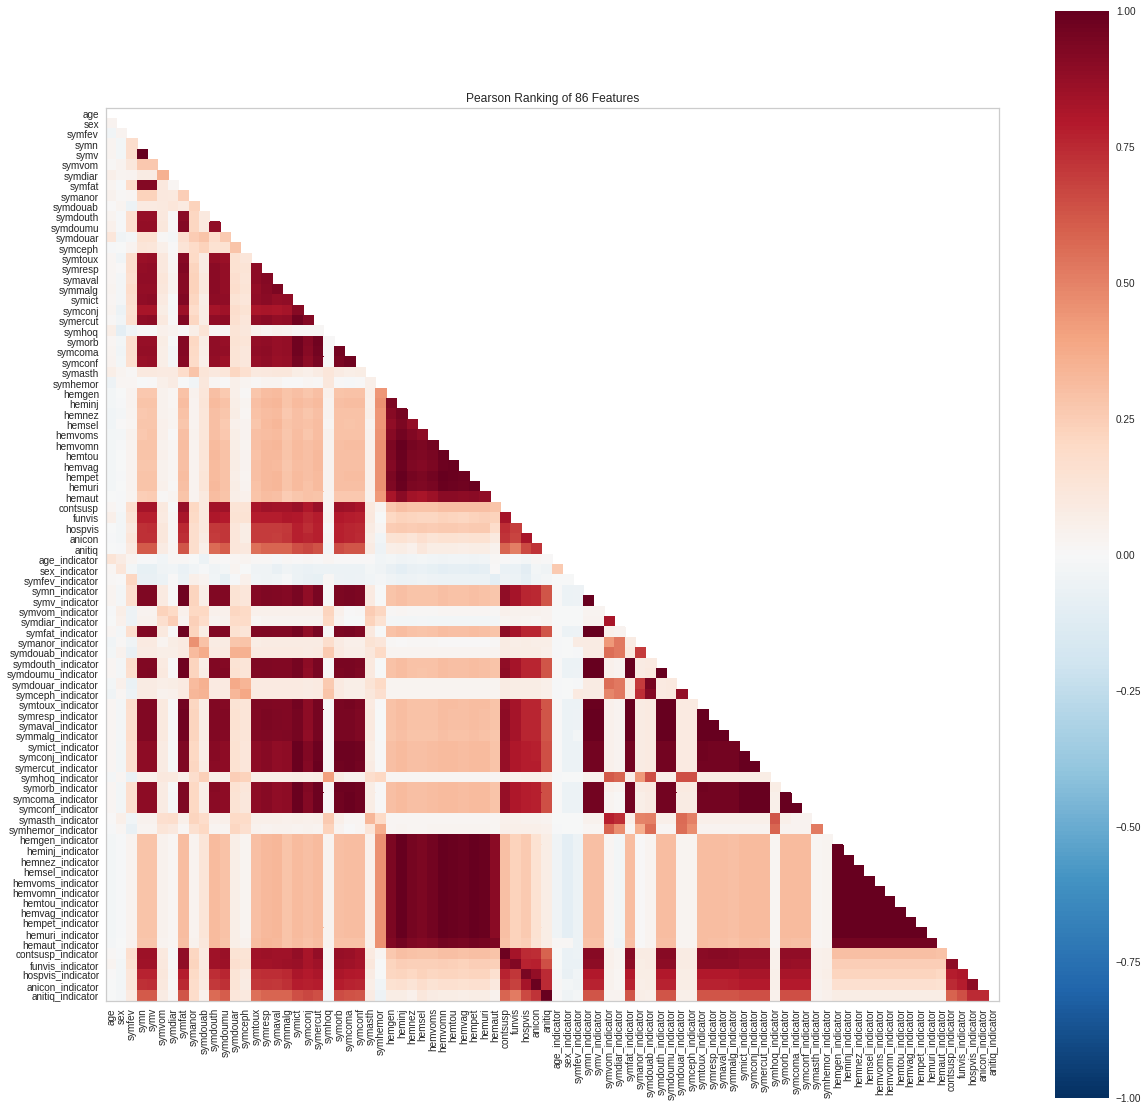

In [123]:
Corr_vision(X_out_extra)

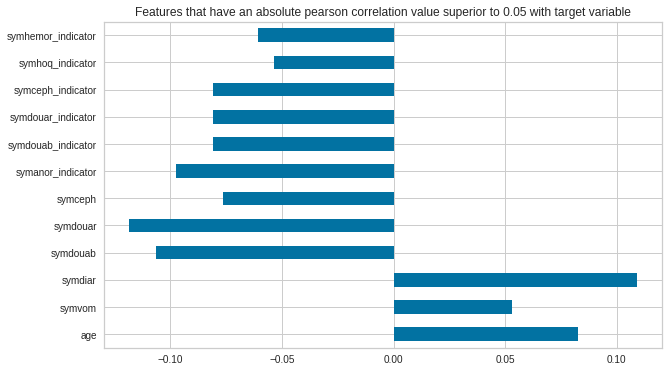

In [124]:
X_y = X_out_extra.join(y_out_extra)
corr_matrix = X_y.corr()

corr_y = corr_matrix['outcome']
threshold = 0.05
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

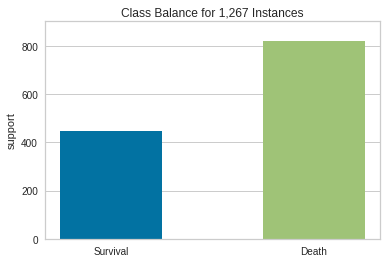

In [125]:
Imbalance_out(y_out_extra)

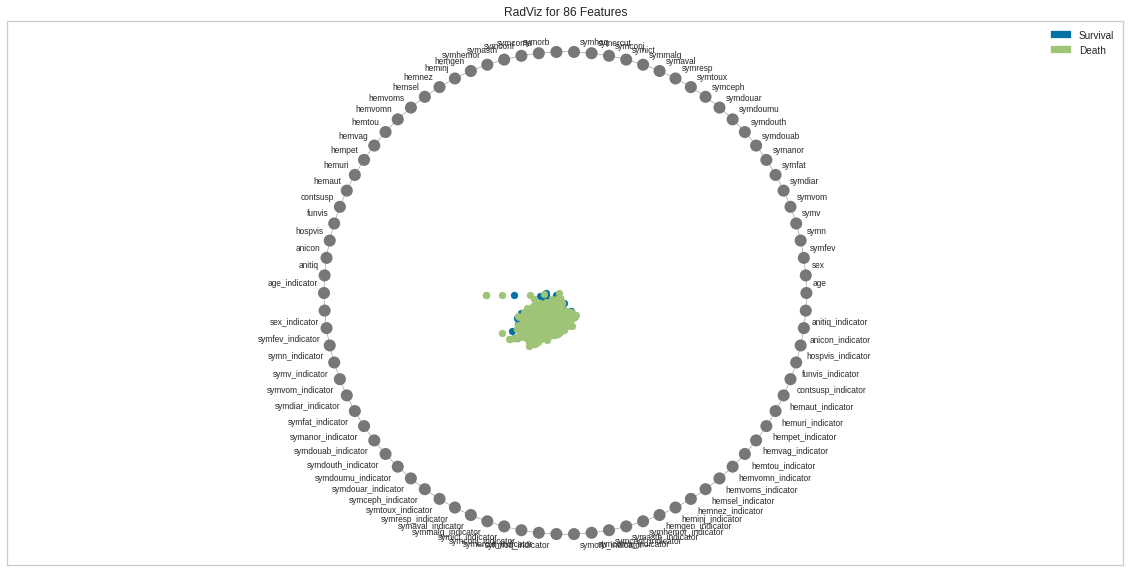

In [126]:
Rad_vision_out(X_out_extra, y_out_extra)

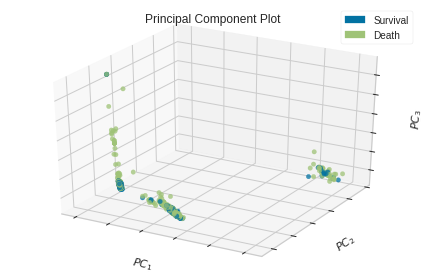

In [127]:
PCA_vision_3D_out(X_out_extra, y_out_extra.astype('int'))

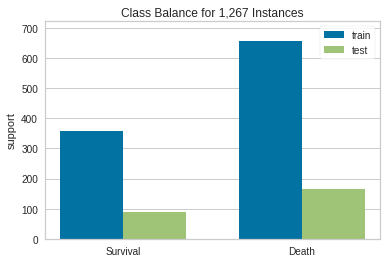

In [128]:
X_out_extra_train, X_out_extra_test, y_out_extra_train, y_out_extra_test = train_test_split(X_out_extra, y_out_extra, test_size=0.2, random_state=123, stratify=y_out_extra)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Survival', 'Death'])

visualizer.fit(y_out_extra_train, y_out_extra_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [129]:
# standardize age for df_out_extra

scaler2 = StandardScaler()
X_out_extra_train['age'] = scaler1.fit_transform(X_out_extra_train['age'].to_numpy().reshape(-1, 1))  
X_out_extra_test['age'] = scaler1.transform(X_out_extra_test['age'].to_numpy().reshape(-1, 1))

<ipython-input-129-4de9f1be5126>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_out_extra_train['age'] = scaler1.fit_transform(X_out_extra_train['age'].to_numpy().reshape(-1, 1))
<ipython-input-129-4de9f1be5126>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_out_extra_test['age'] = scaler1.transform(X_out_extra_test['age'].to_numpy().reshape(-1, 1))


### ML models

#### For reference

In [130]:
y_ebo_ref = np.ones(len(y_out_extra_test))
accuracy_test = accuracy_score(y_out_extra_test, y_ebo_ref)
fpr_test, tpr_test, thresholds_test = roc_curve(y_out_extra_test, y_ebo_ref)
auc_test = auc(fpr_test, tpr_test)
print("Area Under the curve accuracy on test set: ", auc_test)
print("Accuracy for test set: ",accuracy_test)
print("F1-score for test set: ", f1_score(y_out_extra_test, y_ebo_ref))

Area Under the curve accuracy on test set:  0.5
Accuracy for test set:  0.6496062992125984
F1-score for test set:  0.7875894988066825


In [131]:
extra_decision_tree_out = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 26)],
    'max_leaf_nodes':[i for i in range(6, 17)]
}

In [132]:
gsearch = GridSearchCV(
    estimator= extra_decision_tree_out,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=-1,
    iid=False,
    cv=5
)
gsearch.fit(X_out_extra_train, y_out_extra_train)

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_leaf_nodes': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                            16],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25]},
             scoring='roc_auc')

In [133]:
clf_best_extra_tree_out = tree.DecisionTreeClassifier(
    random_state=123, 
    max_depth=         gsearch.best_params_['max_depth'], 
    min_samples_split= gsearch.best_params_['min_samples_split'],
    max_leaf_nodes=    gsearch.best_params_['max_leaf_nodes']
)
clf_best_extra_tree_out.fit(X_out_extra_train, y_out_extra_train)
y_out_extra_pred = clf_best_extra_tree_out.predict(X_out_extra_test)
accuracy_test = accuracy_score(y_out_extra_test, y_out_extra_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_out_extra_test, y_out_extra_pred)
auc_test = auc(fpr_test, tpr_test)
print("Area under the curve on test set :",auc_test)
print("Accuracy of test set :",accuracy_test)

Area under the curve on test set : 0.545692883895131
Accuracy of test set : 0.6417322834645669


## Third proposition of data frame for outcome 

In [134]:
df_ml.head()

,msfid,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,symdiar,...,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes,epistat
0,G10,35.0,-1,-1,0,1,0,1,1,1,...,0,1,0,1,0,-1,0,1,0,1
1,G100,40.0,-1,101,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1
2,G1000,40.0,260,-1,1,0,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
3,G1001,8.0,260,262,0,1,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
4,G1002,12.0,258,262,0,1,0,1,1,1,...,1,0,1,0,0,-1,0,1,0,1


First concatenate df_outcome (cleaned, but we need to still remove -1 "the unknwons") with msfid, in order to merge with df_rid 



In [135]:
df_outcome = df_outcome.astype('int')
df_temp = pd.concat([df_outcome, df_linelist['msfid']], axis = 1, join = 'outer')
df_temp.head()

,outcome,msfid
0,1,G1
1,1,G10
2,0,G100
3,1,G1000
4,1,G1001


In [136]:
df_out_rid = df_temp[df_temp['outcome'] != -1]
df_out_rid = df_out_rid.merge(df_ml,on = 'msfid')
# We predict the outcome only on ebola postive people, by outcome we mean (dead, not dead)
df_out_rid['epistat'] =df_out_rid['epistat'].replace(0, np.nan)
df_out_rid.dropna(axis = 0, inplace = True)
df_out_rid.head()

,outcome,msfid,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,...,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes,epistat
0,1,G10,35.0,-1,-1,0,1,0,1,1,...,0,1,0,1,0,-1,0,1,0,1.0
1,0,G100,40.0,-1,101,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
2,1,G1000,40.0,260,-1,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
3,1,G1001,8.0,260,262,0,1,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
4,0,G1002,12.0,258,262,0,1,0,1,1,...,1,0,1,0,0,-1,0,1,0,1.0


In [137]:
# Let's drop msfid and epistat

df_out_rid.drop(['msfid','epistat'], inplace= True, axis = 1)


In [138]:
# This is now the third dataframe to predict the outcome knowing your patient is positive 
df_out_rid.head()

,outcome,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,symdiar,...,conttyp_Alive,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes
0,1,35.0,-1,-1,0,1,0,1,1,1,...,0,0,1,0,1,0,-1,0,1,0
1,0,40.0,-1,101,1,0,0,1,0,0,...,0,0,1,0,1,0,-1,0,1,0
2,1,40.0,260,-1,1,0,0,1,0,1,...,0,0,1,0,1,0,-1,0,1,0
3,1,8.0,260,262,0,1,0,1,0,1,...,0,0,1,0,1,0,-1,0,1,0
4,0,12.0,258,262,0,1,0,1,1,1,...,0,1,0,1,0,0,-1,0,1,0


In [139]:

X_out_ml = df_out_rid.drop(columns = ['outcome'])
y_out_ml = df_out_rid['outcome']

#### We note that this column has only zero and we'll drop it

In [140]:
X_out_ml['respref_Dinguiraye'].value_counts()

0    1137
Name: respref_Dinguiraye, dtype: int64

In [141]:
X_out_ml.drop(columns=['respref_Dinguiraye'], inplace = True)

#### Correlation matrix 

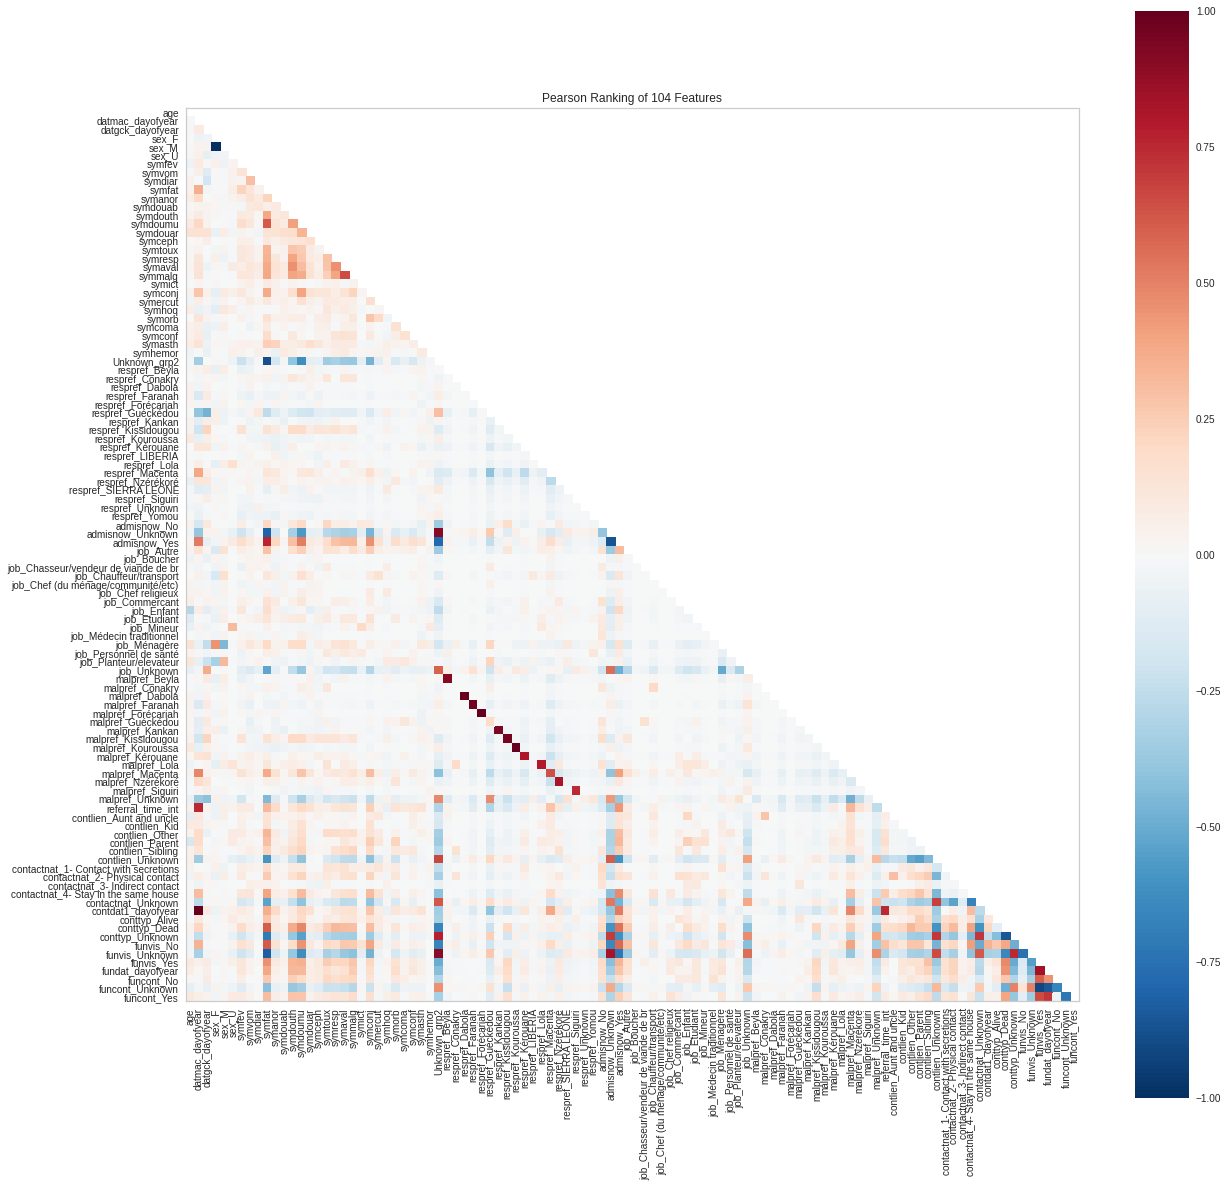

In [142]:
Corr_vision(X_out_ml)

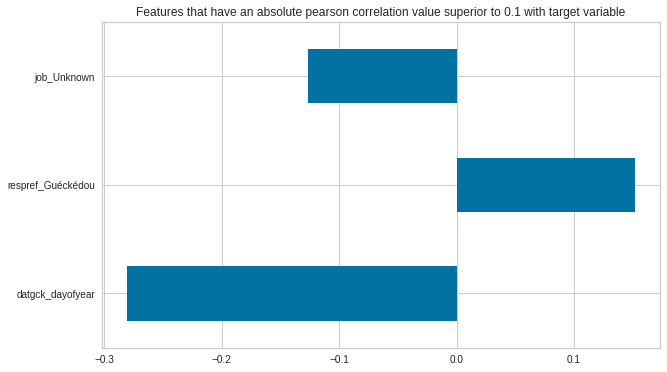

In [143]:
X_y_out = X_out_ml.join(y_out_ml, how = 'outer')
corr_matrix = X_y_out.corr()

corr_y = corr_matrix['outcome']
threshold = 0.1
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()



### Class imbalance

Balance is important in order to get a reliable accuracy for unseen datas, if imbalanced, steps need to be taken in order to take this into account. 
A good metric to look at is precision, recall and F1, this is discussed in the report. 

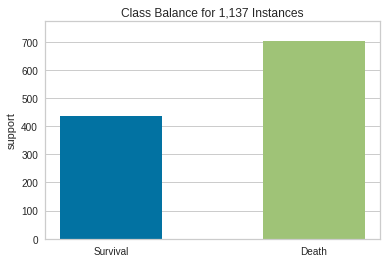

In [144]:
Imbalance_out(y_out_ml)

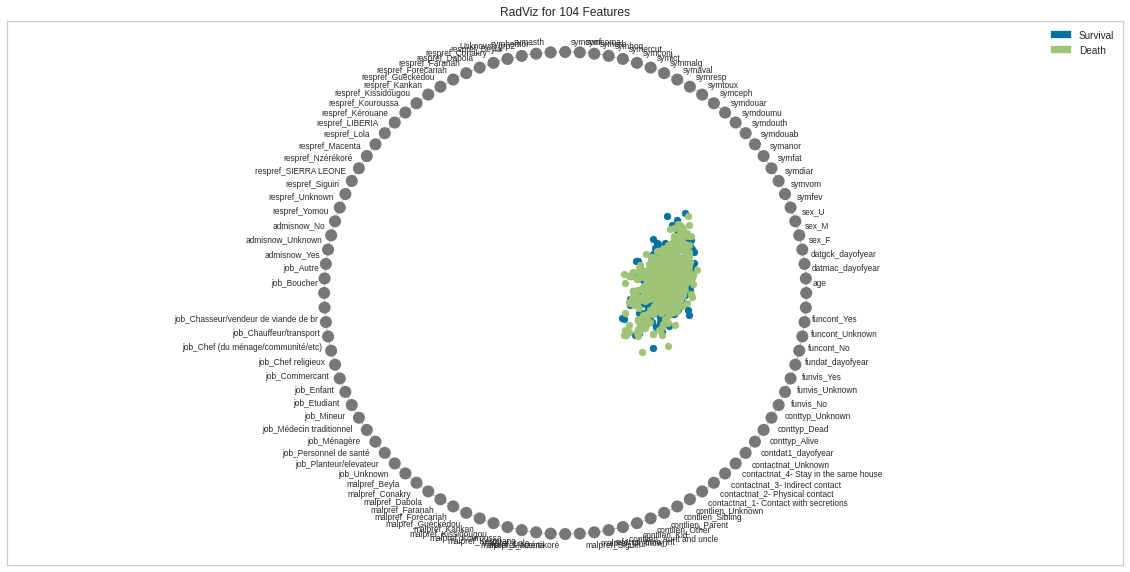

In [145]:
Rad_vision_out(X_out_ml, y_out_ml)

The plot above does not tell us much, we would have wished for a distinction of colors between ebola positive and negative patients

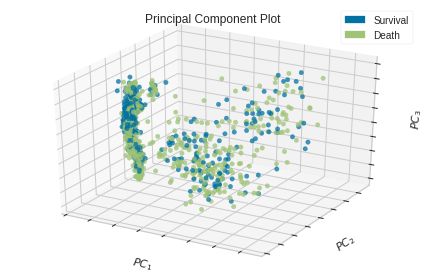

In [146]:
PCA_vision_3D_out(X_out_ml, y_out_ml)

#### We are in a high dimension dataset, let's try Manifold

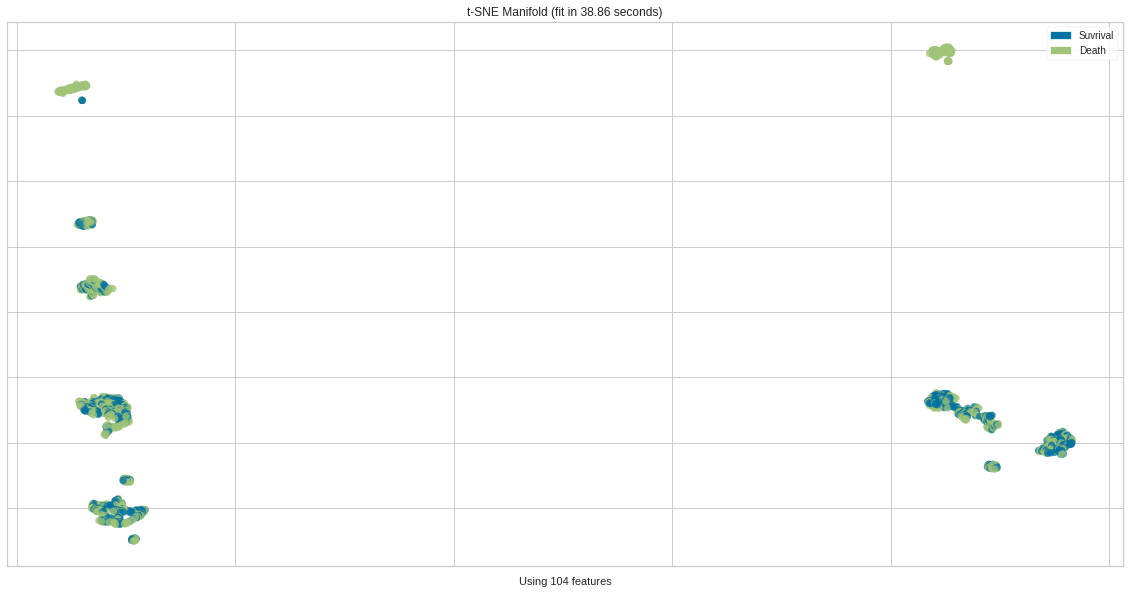

In [147]:
fig, ax = plt.subplots(figsize=(20,10))
# Instantiate the visualizer
viz = Manifold(manifold="tsne",  classes=['Suvrival', 'Death'])
viz.fit_transform(X_out_ml, y_out_ml)  # Fit the data to the visualizer
viz.show()               # Finalize and render the figure
plt.show()

##### Split train/test

Before standardizing, we need to make sure that the dataset is split between train and test !
This is to make sure that the "way" we standardize our train set is "the base" as to how we standardize our test set.

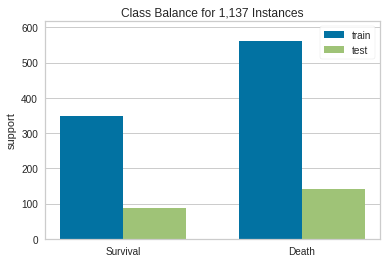

In [148]:

X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(X_out_ml, y_out_ml, test_size=0.2, random_state=123, stratify=y_out_ml)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Survival', 'Death'])

visualizer.fit(y_out_train, y_out_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

##### Normalizing the data


In [149]:
scaler3 = StandardScaler()
numerical_col = ['age','datmac_dayofyear', 'datgck_dayofyear', 'referral_time_int', 'contdat1_dayofyear','fundat_dayofyear']
X_out_train.loc[:,numerical_col] = scaler3.fit_transform(X_out_train[numerical_col])
X_out_test.loc[:,numerical_col] = scaler3.transform(X_out_test[numerical_col])

/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# ML Models

#### For reference

In [150]:
y_ebo_ref = np.ones(len(y_out_test))
accuracy_test = accuracy_score(y_out_test, y_ebo_ref)
fpr_test, tpr_test, thresholds_test = roc_curve(y_out_test, y_ebo_ref)
auc_test = auc(fpr_test, tpr_test)
print("Area Under the curve accuracy on test set: ", auc_test)
print("Accuracy for test set: ",accuracy_test)
print("F1-score for test set: ", f1_score(y_out_test, y_ebo_ref))

Area Under the curve accuracy on test set:  0.5
Accuracy for test set:  0.618421052631579
F1-score for test set:  0.7642276422764228


### SVM

Use of validation curve to determine a plausible area for the hyper-parameters
- gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
- C: Regularization parameter (the strength of the regularization is inversely proportional to C)
- kernel: kernel type to be used in the algorithm

For a linear kernel, we just need to optimize the c parameter. However, if we want to use an RBF kernel, both c and gamma parameter need to optimized simultaneously.
So in our case we tune both hyperparameters.

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


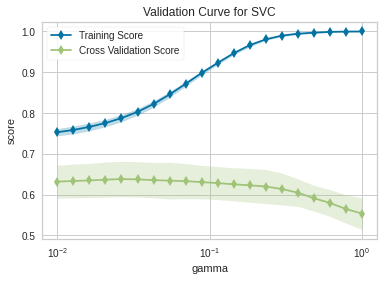

In [151]:
# Validation curve for gamma parameter 
cv = cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=123)
#cv = cv = StratifiedKFold(n_splits=5, random_state=123)

param_range = np.logspace(-2, 0, 20)

viz = ValidationCurve(SVC(random_state=123), param_name="gamma", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


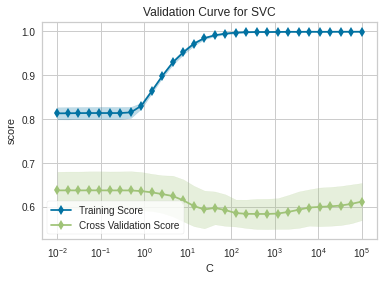

In [152]:
# Validation curve for C parameter 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=123)
#cv = cv = StratifiedKFold(n_splits=5, random_state=123)
param_range = np.logspace(-2, 5, 30)

viz = ValidationCurve(SVC(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [153]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(0, 2, 30), 'gamma' : np.logspace(-2, 0, 30)}
svc = svm.SVC(random_state=123)

clf = GridSearchCV(svc, parameters, scoring = 'roc_auc', n_jobs=-1, cv=cv)
clf.fit(X_out_train, y_out_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=123),
             estimator=SVC(random_state=123), n_jobs=-1,
             param_grid={'C': array([  1.        ,   1.1721023 ,   1.3738238 ,   1.61026203,
         1.88739182,   2.21221629,   2.5929438 ,   3.03919538,
         3.56224789,   4.17531894,   4.89390092,   5.73615251,
         6.72335754,   7.88046282,   9.23670857,  10.82636734,
        12.68961003,  14.87352107,  17.43328822,  20...
                         'gamma': array([0.01      , 0.01172102, 0.01373824, 0.01610262, 0.01887392,
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
         

In [154]:
clf.best_params_

{'C': 2.592943797404667, 'gamma': 0.018873918221350976, 'kernel': 'rbf'}

SVC:
On training we get an Accuracy 0.7073707370737073, an AUC 0.6423643124961583 and F1 score 0.7950693374422187 
For test we get an Accuracy 0.631578947368421, an AUC 0.5590608950843727 and F1 score 0.7439024390243902


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Can plot ROC curve for this model
Don't have feature importance


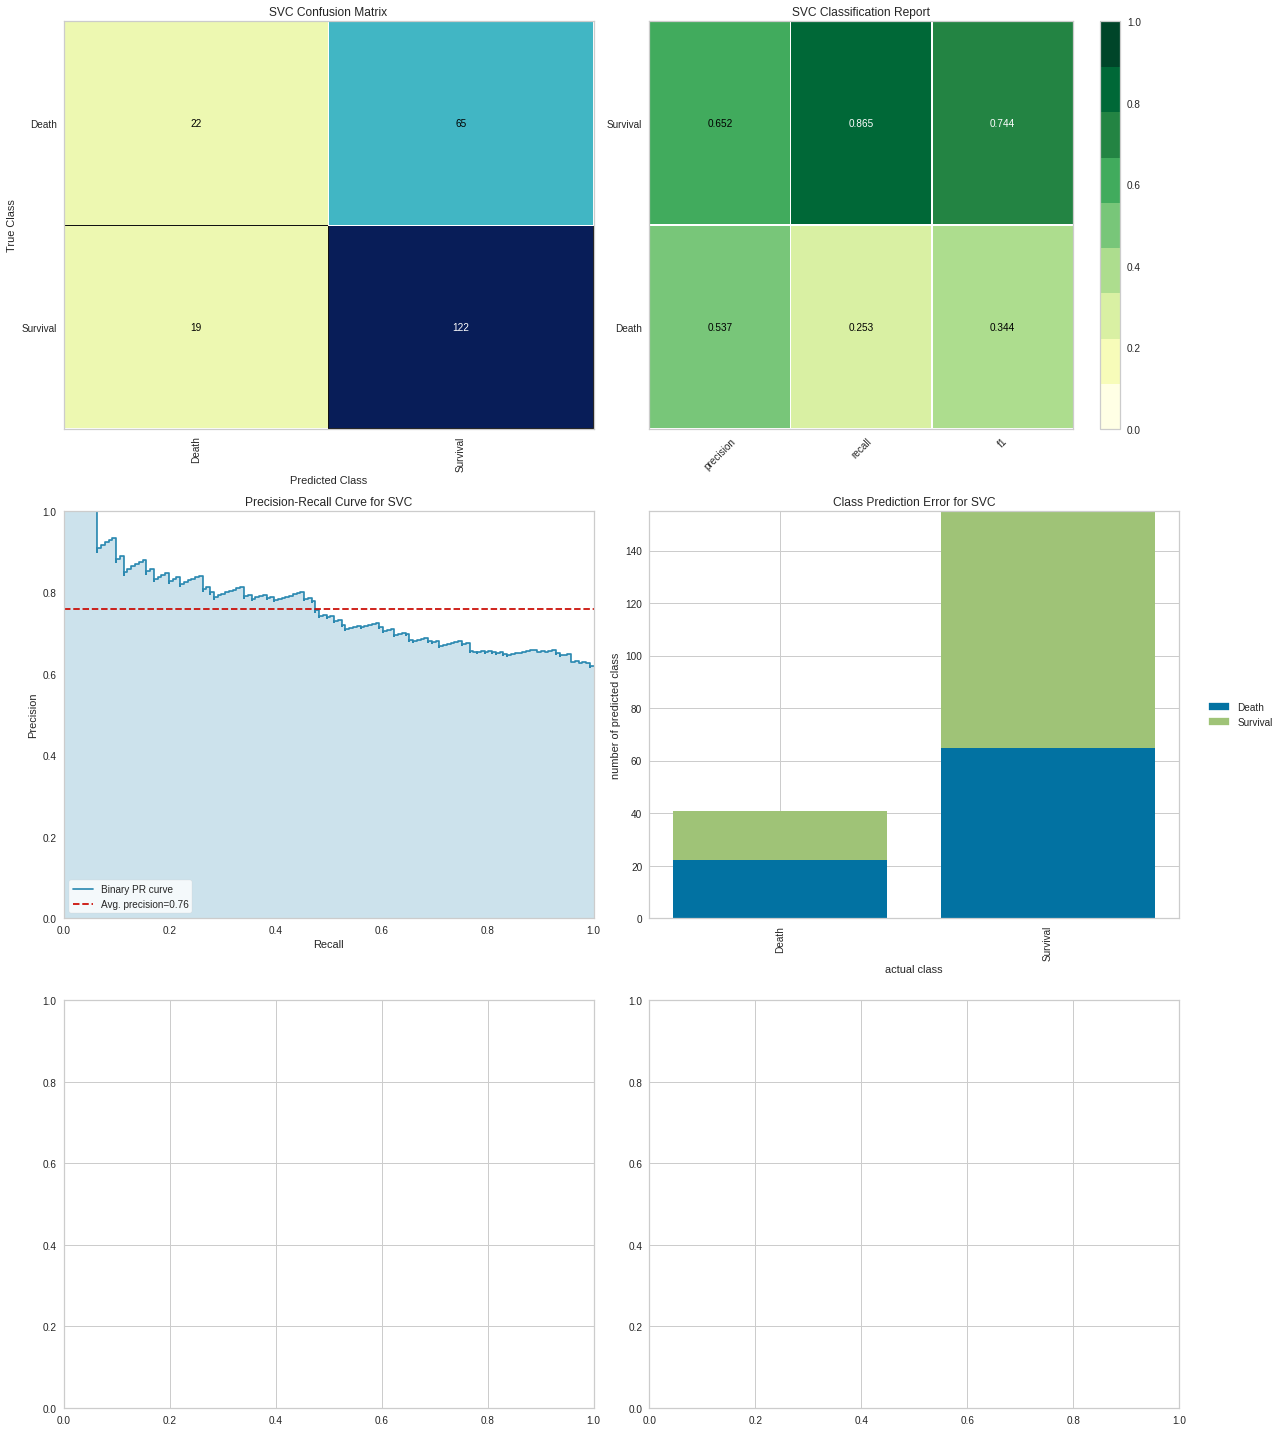

In [155]:
svc = svm.SVC(
    random_state=123,
    C= clf.best_params_['C'], 
    gamma = clf.best_params_['gamma'], 
    kernel = clf.best_params_['kernel']
)
score_model_outcome(X_out_train, y_out_train, X_out_test, y_out_test, svc)

In [156]:
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2,random_state=123)
#cv = StratifiedKFold(n_splits=2, random_state=123)

parameters = {'C': np.logspace(0, 2, 30), 'gamma' : np.logspace(-2, 0, 30)}
svc_linear = svm.SVC(random_state=123)

clf_linear = GridSearchCV(svc_linear, parameters, scoring = 'roc_auc', n_jobs=-1, cv=cv)
clf_linear.fit(X_out_train, y_out_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=2, random_state=123),
             estimator=SVC(random_state=123), n_jobs=-1,
             param_grid={'C': array([  1.        ,   1.1721023 ,   1.3738238 ,   1.61026203,
         1.88739182,   2.21221629,   2.5929438 ,   3.03919538,
         3.56224789,   4.17531894,   4.89390092,   5.73615251,
         6.72335754,   7.88046282,   9.23670857,  10.82636734,
        12.68961003,  14.87352107,  17.43328822,  20...
                         'gamma': array([0.01      , 0.01172102, 0.01373824, 0.01610262, 0.01887392,
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ])},
             scoring='roc_auc')

In [157]:
clf_linear.best_params_

{'C': 1.0, 'gamma': 0.02592943797404667}

SVC:
On training we get an Accuracy 0.6952695269526953, an AUC 0.6396520990841477 and F1 score 0.7803330689928628 
For test we get an Accuracy 0.6096491228070176, an AUC 0.5501345072144779 and F1 score 0.7174603174603175


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Can plot ROC curve for this model
Don't have feature importance


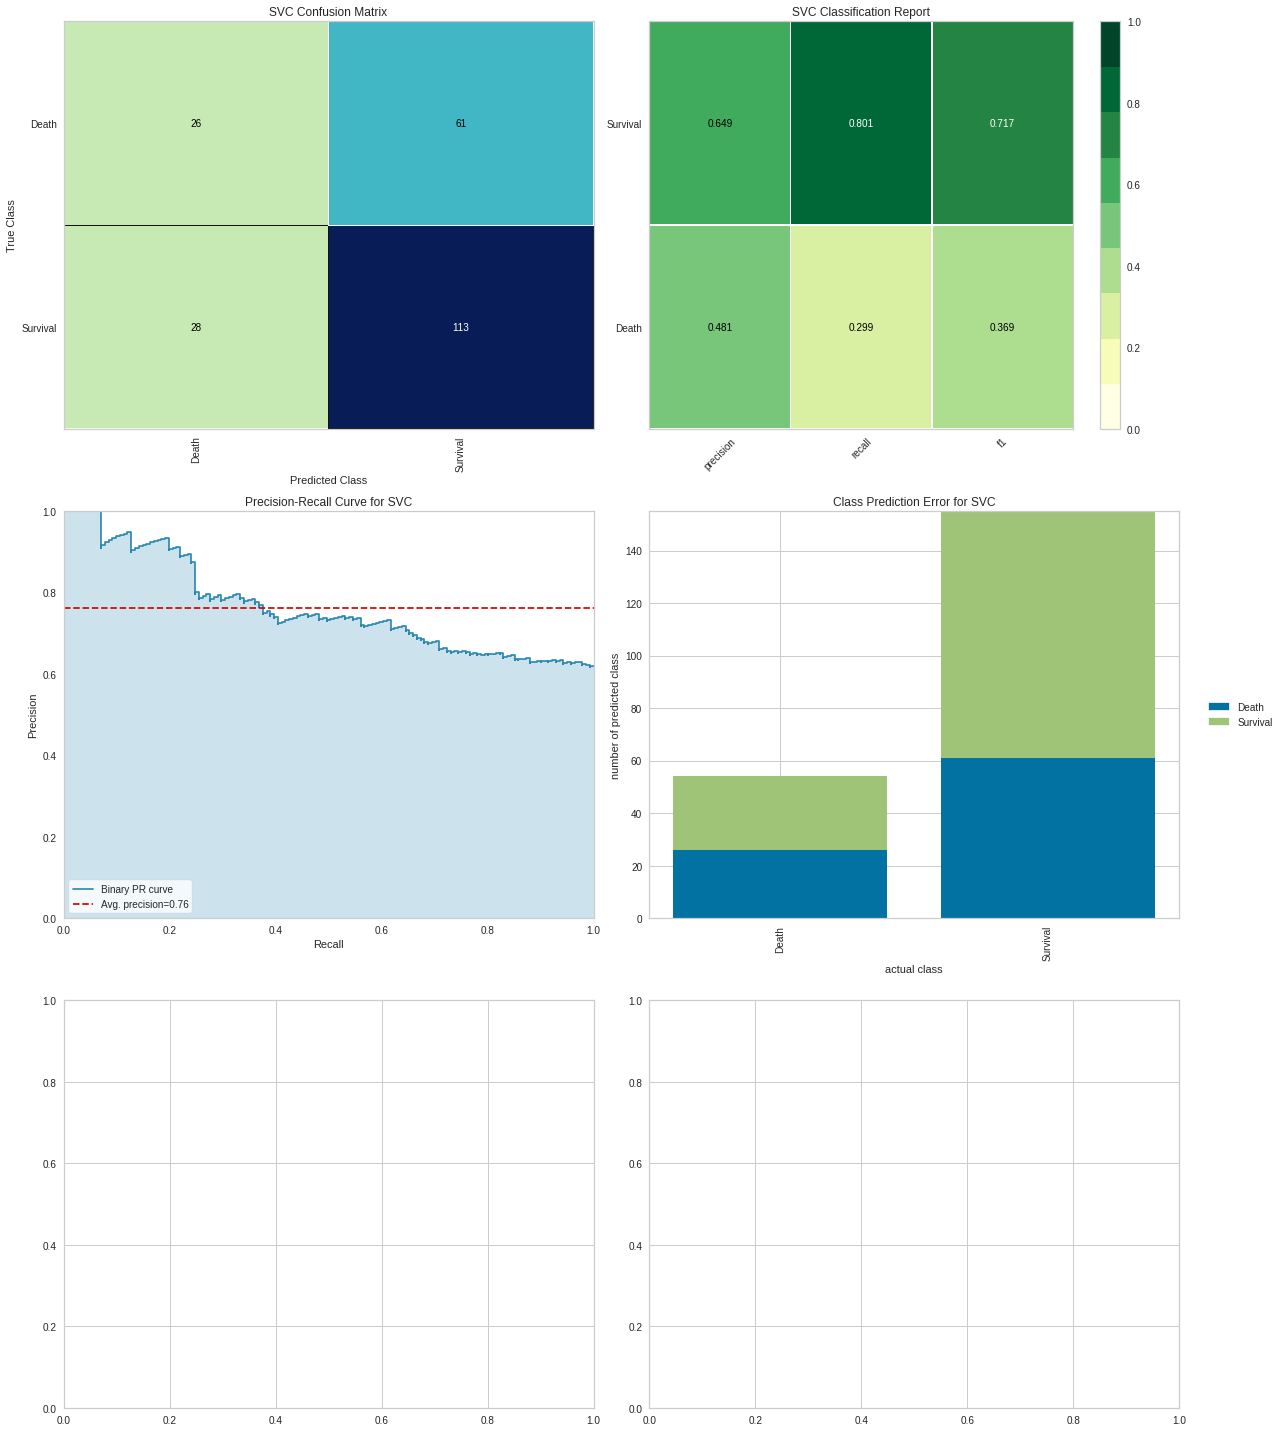

In [158]:
svc_linear = svm.SVC(
    random_state = 123,
    C =      clf.best_params_['C'], 
    gamma =  clf.best_params_['gamma'], 
    kernel = 'linear')
score_model_outcome(X_out_train, y_out_train, X_out_test, y_out_test, svc_linear)

In [159]:
eli5.show_weights(svc_linear, feature_names=list(X_out_ml.columns))

Weight?,Feature
+1.666,symconf
+1.273,job_Chasseur/vendeur de viande de br
+1.235,respref_Unknown
+1.155,symaval
+1.139,malpref_Faranah
+0.950,malpref_Kissidougou
+0.815,symconj
+0.811,malpref_Kérouane
+0.809,symorb
+0.782,malpref_Lola


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:189: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


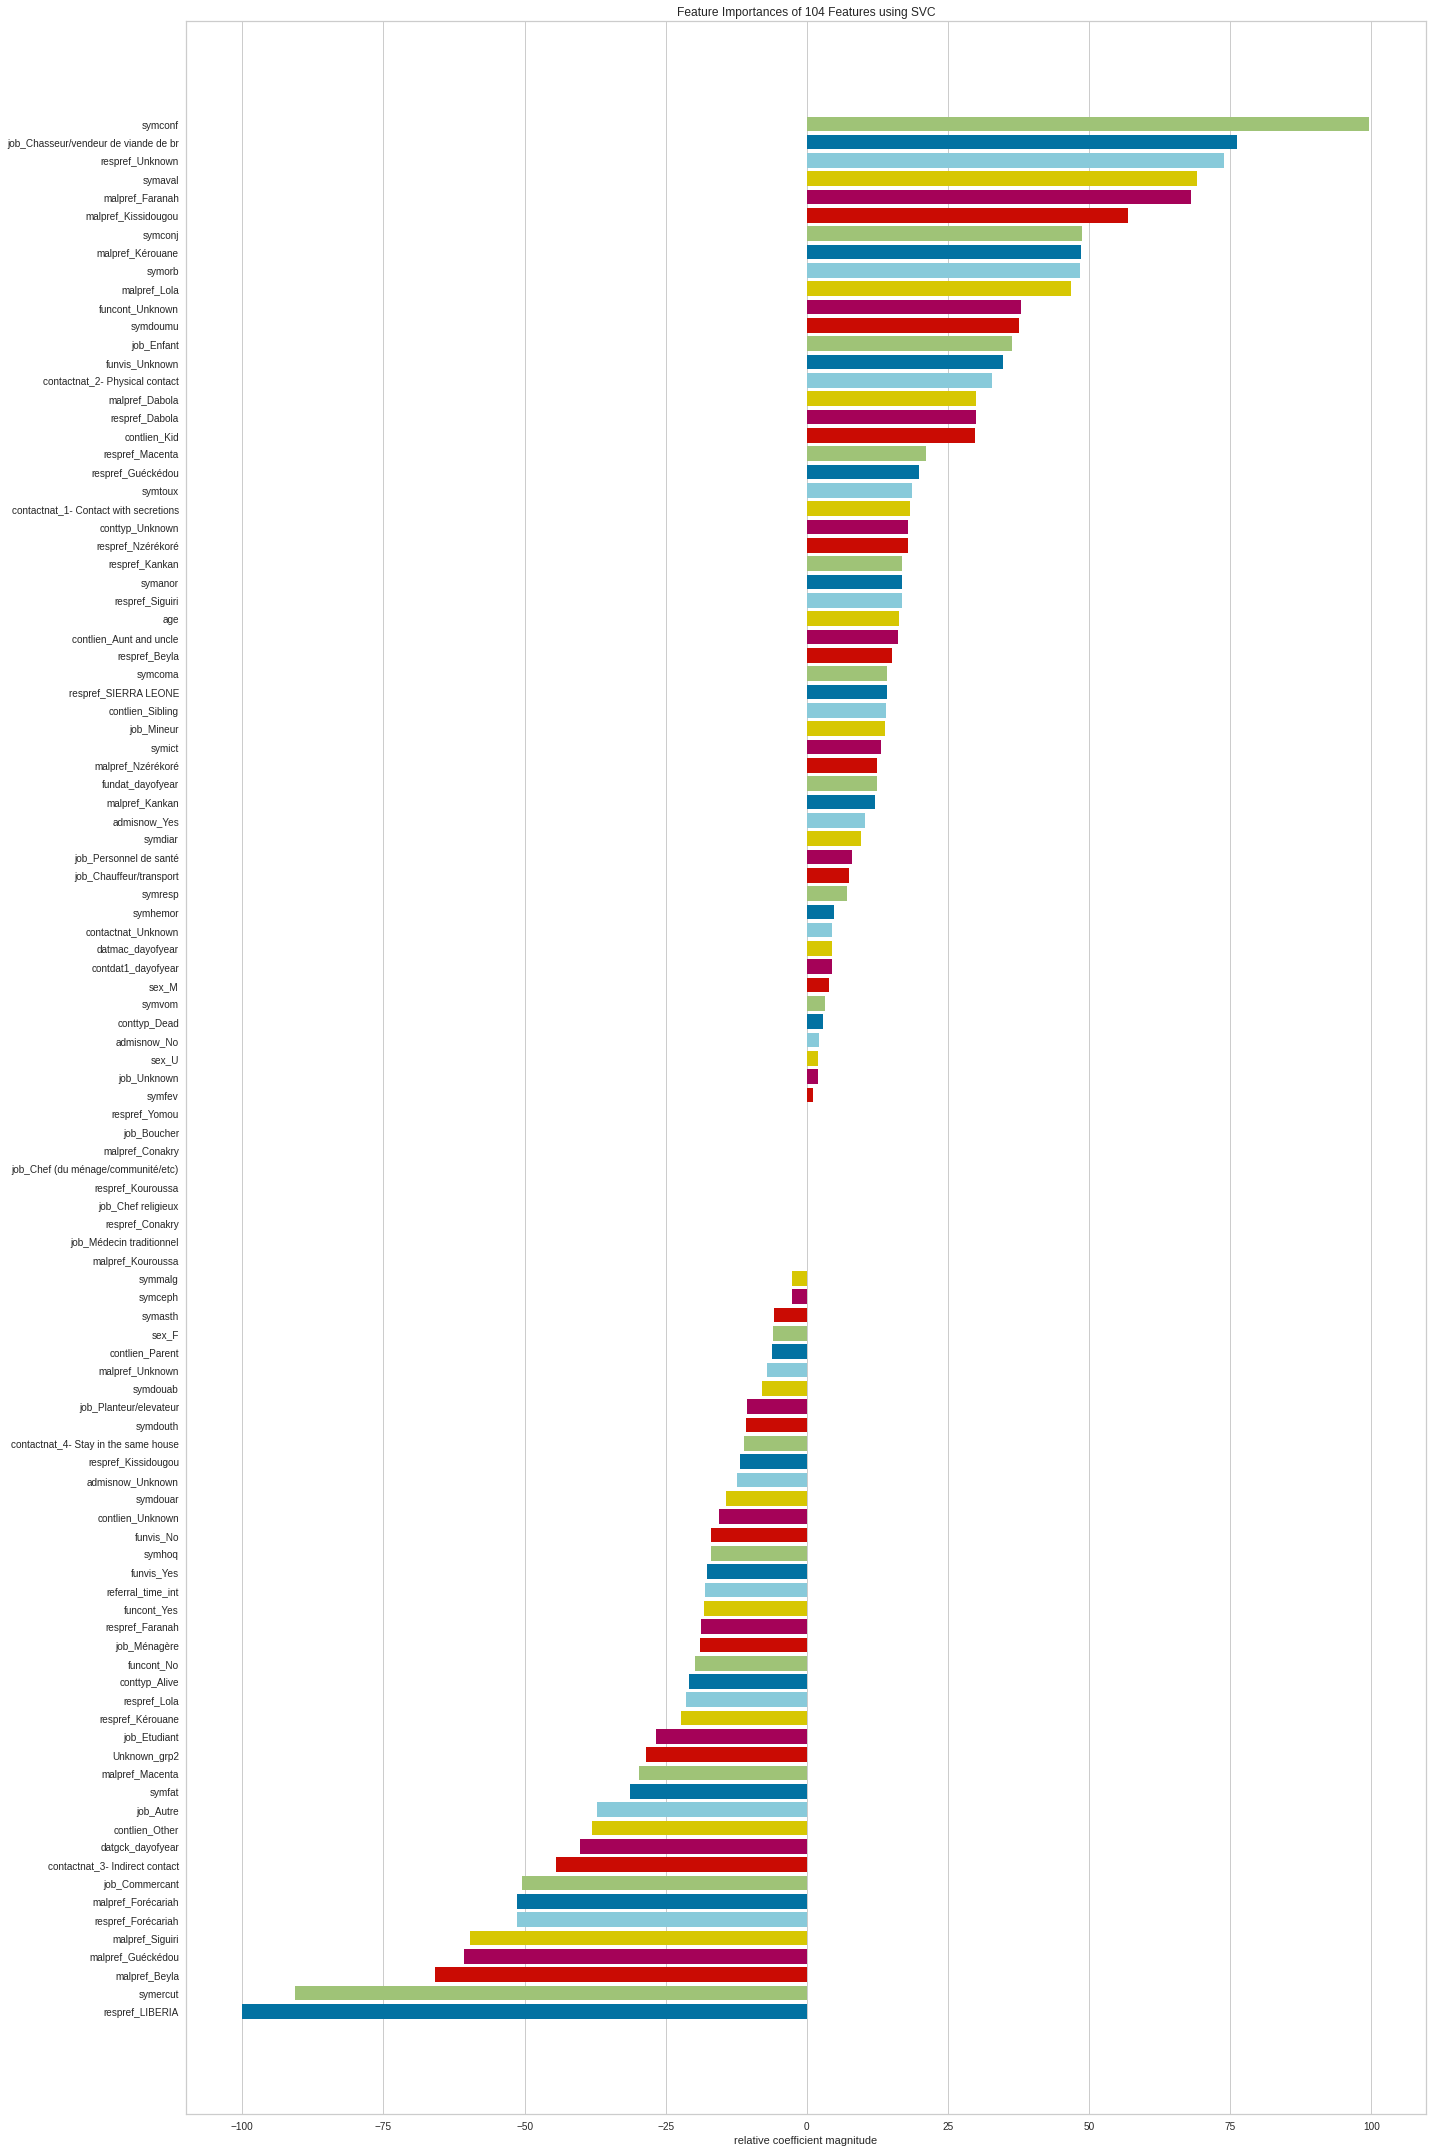

In [160]:
fig, ax = plt.subplots(figsize=(20,30))

viz = FeatureImportances(svc_linear, relative=True)
viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

### Logistic regression

 Use of validation curve to determine a plausible area for the hyper-parameters:
- penalty: norm used for the penalization
- C: inverse of regularization strength

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


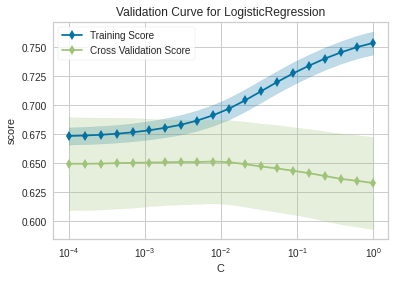

In [161]:
# Validation curve for C parameter 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=123)
param_range = np.logspace(-4, 0, 20)

viz = ValidationCurve(LogisticRegression(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [162]:
parameters = {'penalty': ['l1', 'l2'], 'C' : np.logspace(-3, -1, 30)}
logit = LogisticRegression(random_state=123)

clf = GridSearchCV(logit, parameters, scoring = 'roc_auc', n_jobs=-1, cv=cv)
clf.fit(X_out_train, y_out_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=123),
             estimator=LogisticRegression(random_state=123), n_jobs=-1,
             param_grid={'C': array([0.001     , 0.0011721 , 0.00137382, 0.00161026, 0.00188739,
       0.00221222, 0.00259294, 0.0030392 , 0.00356225, 0.00417532,
       0.0048939 , 0.00573615, 0.00672336, 0.00788046, 0.00923671,
       0.01082637, 0.01268961, 0.01487352, 0.01743329, 0.0204336 ,
       0.02395027, 0.02807216, 0.03290345, 0.0385662 , 0.04520354,
       0.05298317, 0.06210169, 0.07278954, 0.08531679, 0.1       ]),
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [163]:
clf.best_params_

{'C': 0.007880462815669913, 'penalty': 'l2'}

LogisticRegression:
On training we get an Accuracy 0.636963696369637, an AUC 0.5384089372426086 and F1 score 0.7652916073968705 
For test we get an Accuracy 0.6140350877192983, an AUC 0.5074590364392273 and F1 score 0.7541899441340782


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


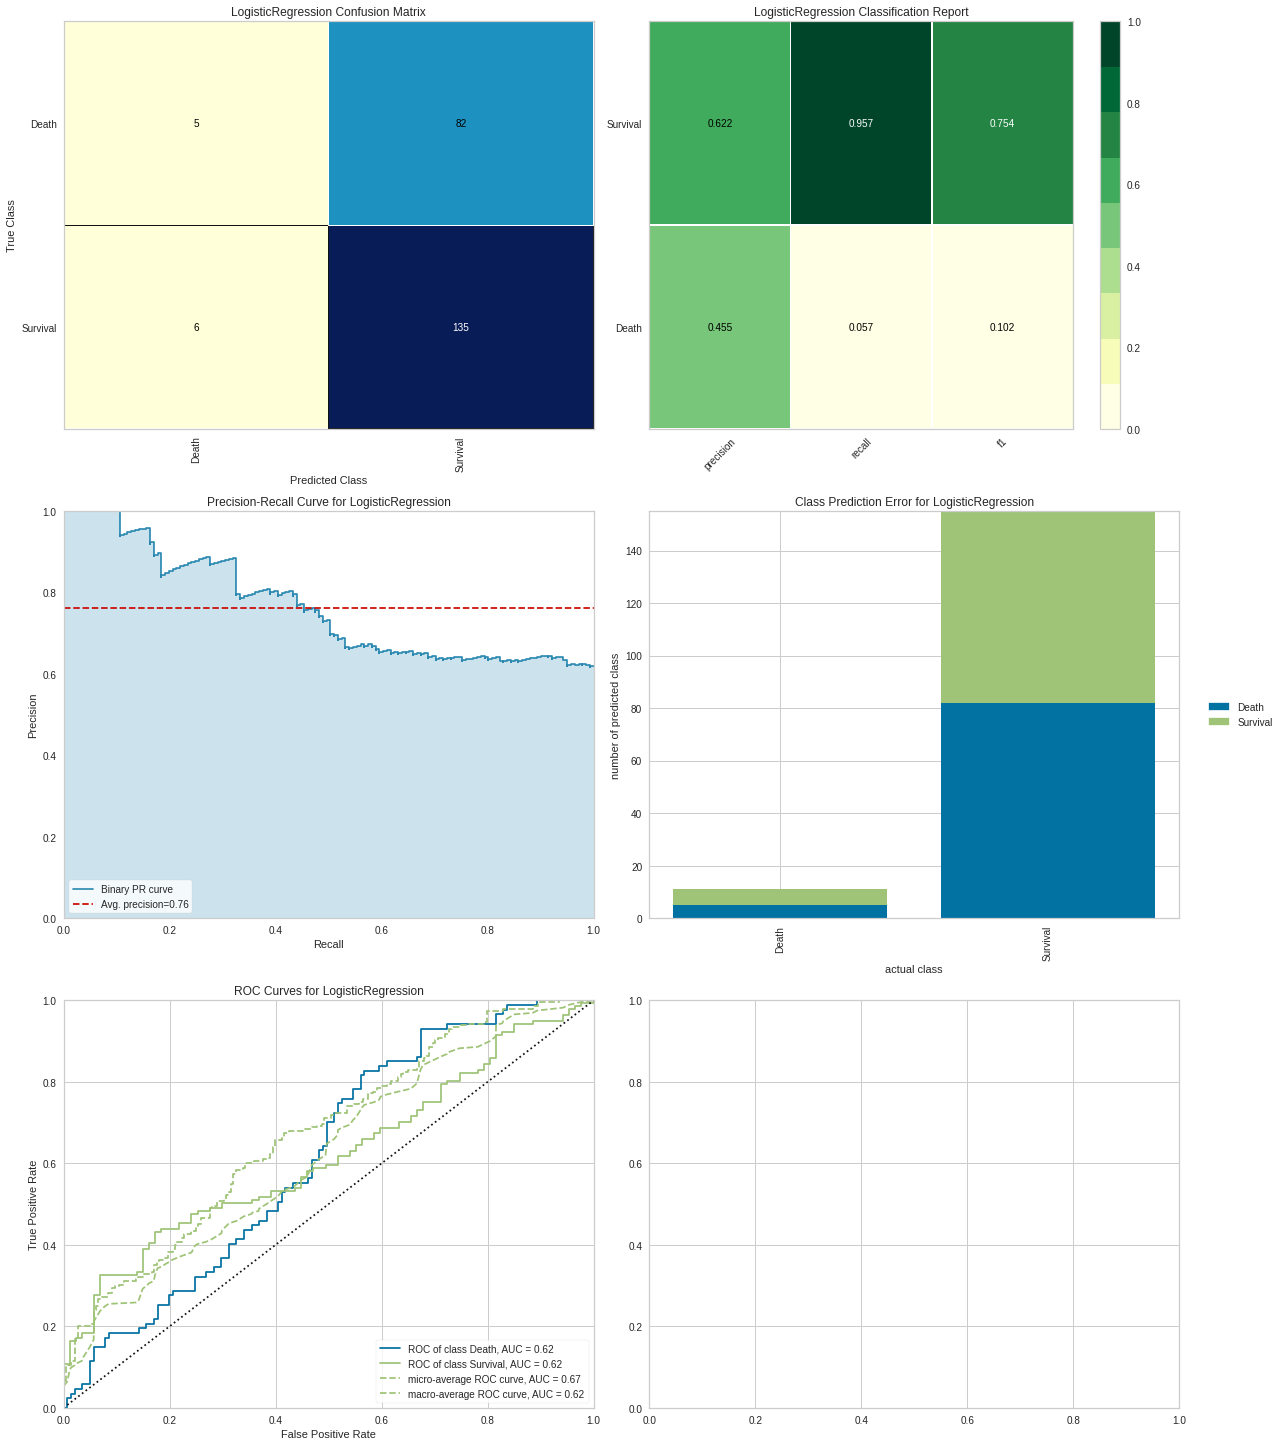

Don't have feature importance




In [164]:
logit = LogisticRegression(
    penalty = clf.best_params_['penalty'], 
    C = clf.best_params_['C']
)
score_model_outcome(X_out_train, y_out_train, X_out_test, y_out_test, logit)

Since results are not good let's verify that if we predict only 'death' the AUC will not be higher than our actual AUC.

In [165]:
prediction_test = np.ones(len(y_out_test))
accuracy_test = accuracy_score(y_out_test, prediction_test)
accuracy_test

0.618421052631579

Resultat un peu gênant....

In [166]:
eli5.show_weights(logit, feature_names=list(X_out_ml.columns))

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:189: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


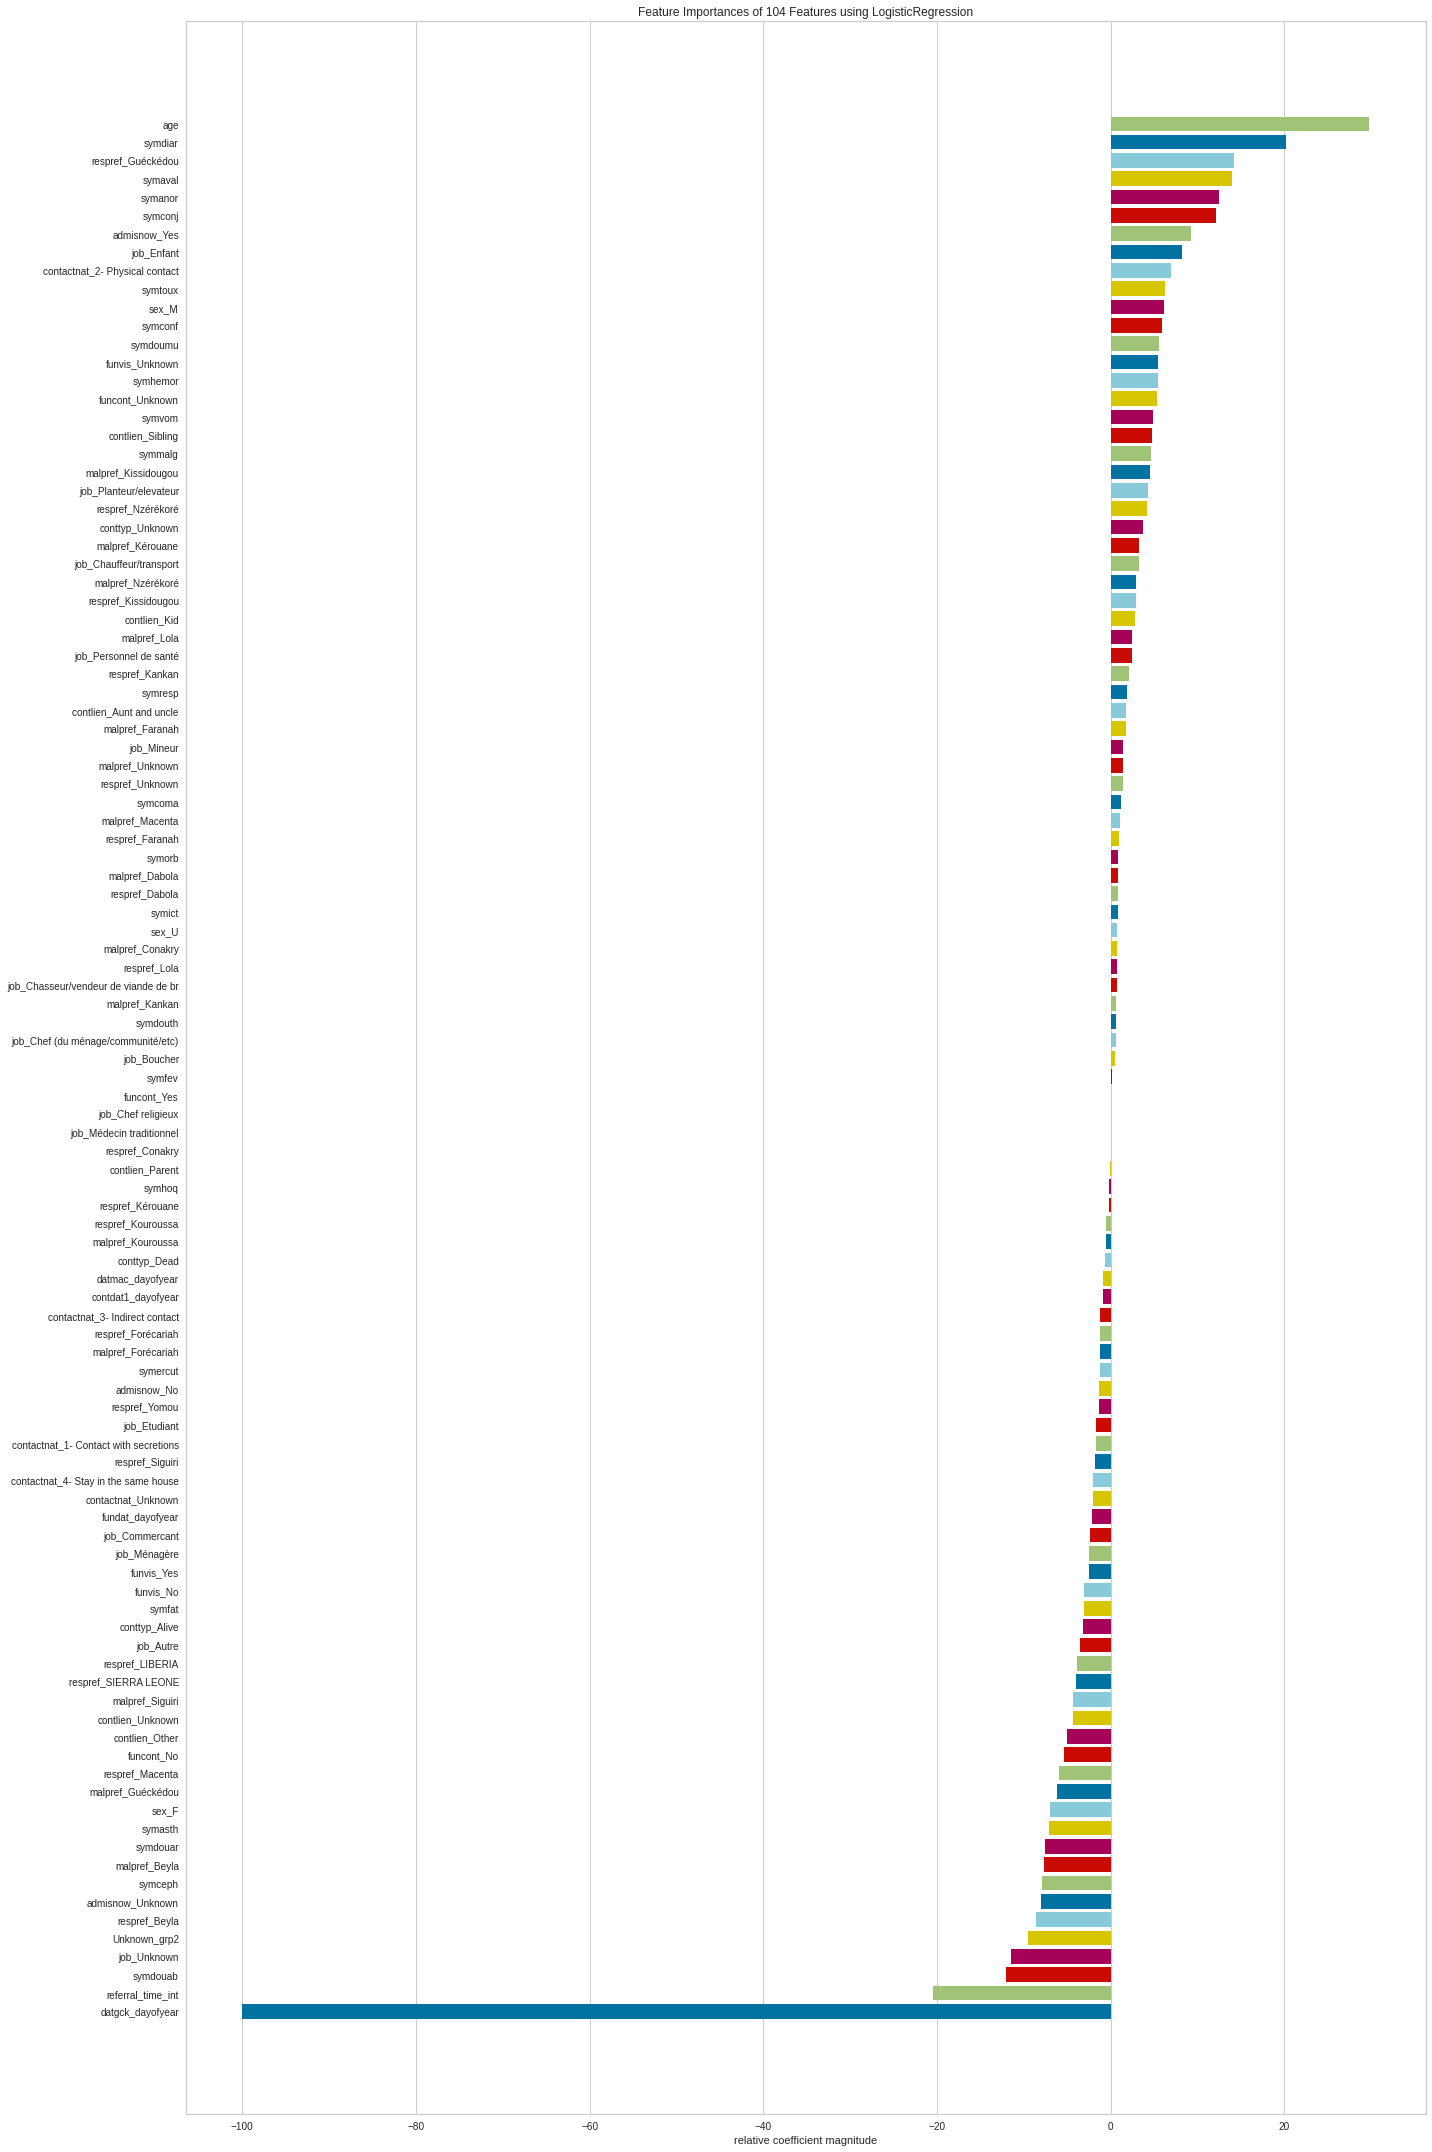

In [167]:
fig, ax = plt.subplots(figsize=(20,30))

viz = FeatureImportances(logit, relative=True)
viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

### Random Forest

 Use of validation curve to determine a plausible area for the hyper-parameters
- n_estimators: Number of trees to build
- max_depth: Maximum depth of tree
- min_samples_split: Data points in nodes before split occurs 

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


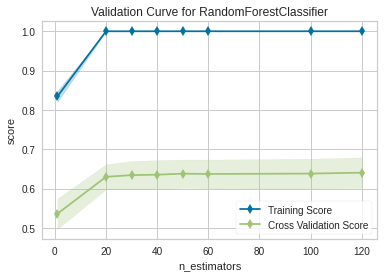

In [168]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=123)
param_range = [1,20,30, 40,50,60,100,120]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="n_estimators", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


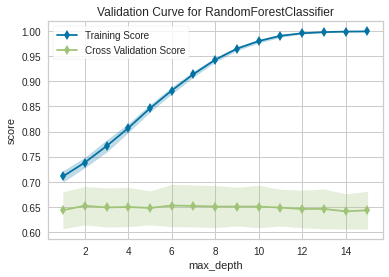

In [169]:
# For max_depth
param_range = [1,2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_depth", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


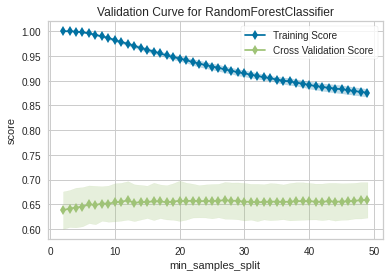

In [170]:
# For min_samples_split

param_range = range(2,50)

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="min_samples_split", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


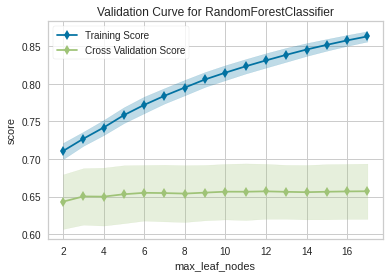

In [171]:
# For max_leaf_nodes
param_range = [2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15,16,17]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_leaf_nodes", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()


In [172]:
param_test = {
    'n_estimators':[30, 40, 50, 60, 100],
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 5)],
    'max_leaf_nodes':[i for i in range(2, 17)]
}
clforest = RandomForestClassifier(random_state = 123)

In [173]:
gsearch = GridSearchCV(
    estimator= clforest,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=4,
    iid=False,
    cv=cv
)
gsearch.fit(X_out_train, y_out_train)
print(gsearch.best_params_)

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'max_depth': 11, 'max_leaf_nodes': 15, 'min_samples_split': 4, 'n_estimators': 100}


In [174]:
clf_best = RandomForestClassifier(n_estimators=     gsearch.best_params_['n_estimators'], 
                                  max_depth=        gsearch.best_params_['max_depth'], 
                                  min_samples_split=gsearch.best_params_['min_samples_split'])
clf_best = clf_best.fit(X_out_train, y_out_train)
y_out_pred = clf_best.predict(X_out_test)
accuracy_test = accuracy_score(y_out_test, y_out_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_out_test, y_out_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test

0.5445096600635853

In [175]:
eli5.show_weights(clf_best, feature_names=list(X_out_ml.columns))

Weight,Feature
0.1785 ± 0.1665,datgck_dayofyear
0.1045 ± 0.0943,age
0.0511 ± 0.0705,datmac_dayofyear
0.0503 ± 0.0651,contdat1_dayofyear
0.0386 ± 0.0509,referral_time_int
0.0250 ± 0.0442,symdiar
0.0210 ± 0.0470,respref_Guéckédou
0.0195 ± 0.0335,symanor
0.0193 ± 0.0343,symceph
0.0166 ± 0.0321,symfev


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


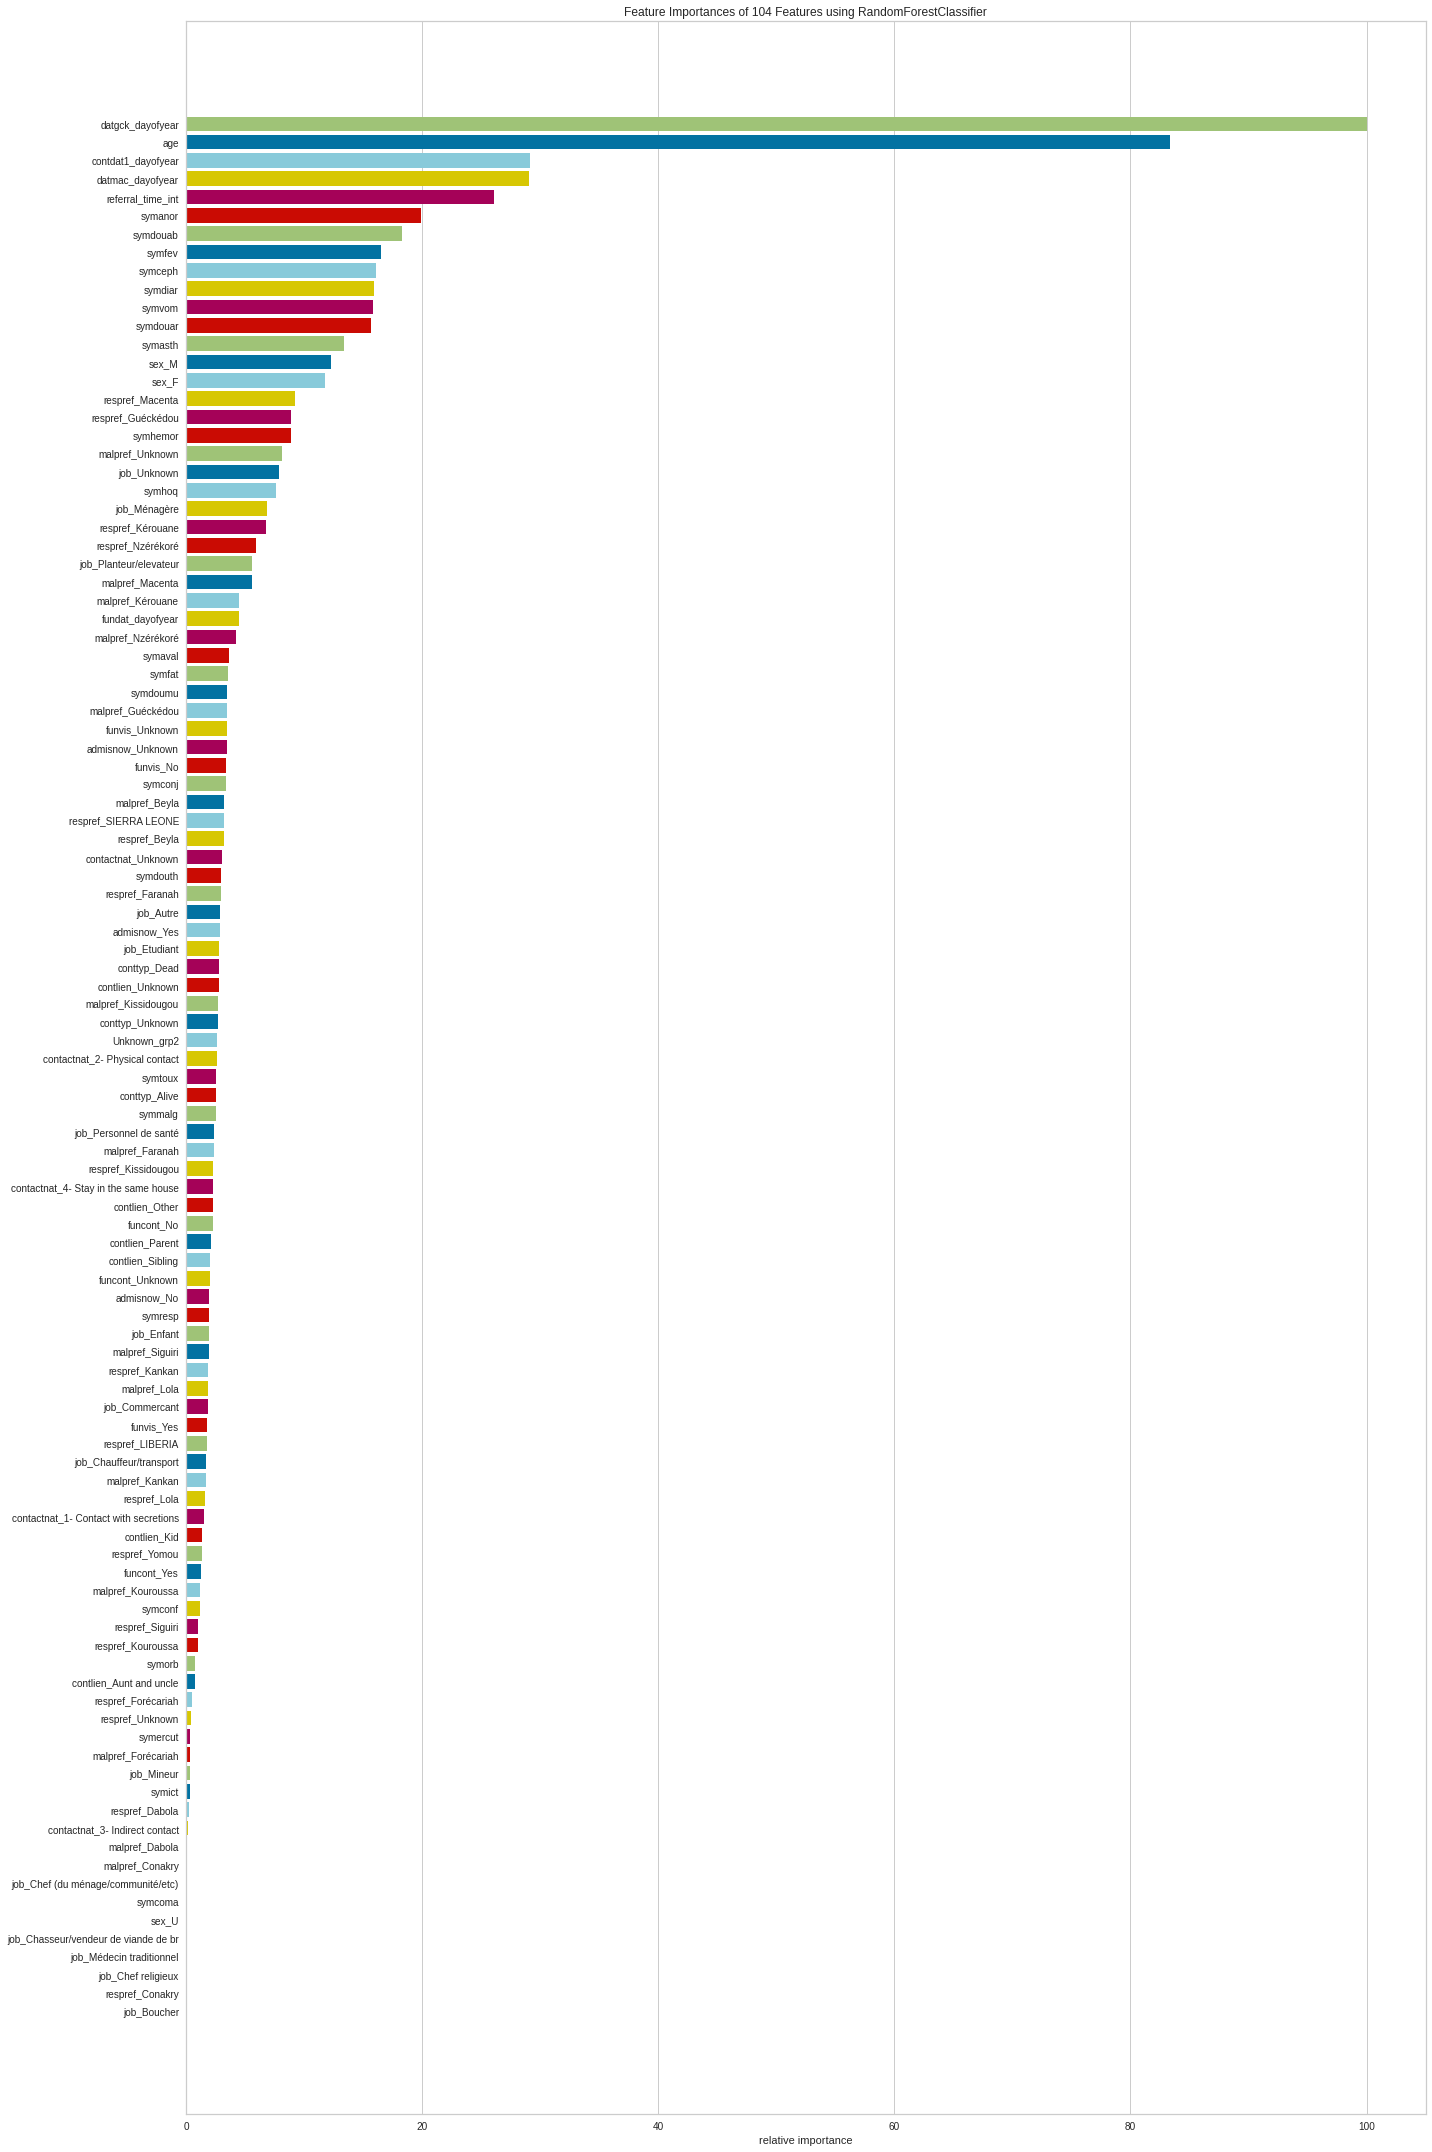

In [176]:
fig, ax = plt.subplots(figsize=(20,30))

viz = FeatureImportances(clforest, relative=True)
viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [177]:
# CO2 cost
cumulator.off() 
cumulator.computation_costs()

345.31009999151036

In [178]:
cumulator.computation_costs()

345.31009999151036